### [DeepDream](https://www.tensorflow.org/tutorials/generative/deepdream)

In [2]:
import tensorflow as tf

# メモリ制限(growth)
# https://qiita.com/studio_haneya/items/4dfaf2fb2ac44818e7e0#%E8%A7%A3%E8%AA%AC
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 画像をロード
img = Image.open("./64564593_p0.png")
np_img = np.asarray(img)

In [4]:
import IPython.display as display

# 損失を計算して合計して返す関数
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.

  # 次元追加
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  # 長さが0だったら配列化する
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

# 画像の正規化
def deprocess(img):
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)
  
# 画像表示
def show(img):
  display.display(Image.fromarray(np.array(img)))

def random_roll(img, maxroll):
  # 画像をランダムな距離だけシフトさせる
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

In [5]:
class TiledGradients(tf.Module):

    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32), # img
            tf.TensorSpec(shape=[], dtype=tf.int32) # tile_size
        )
    )
    def __call__(self, img, tile_size=512):

        # 画像をランダムスライドする
        shift, img_rolled = random_roll(img, tile_size)

        # img_rolledと同じ形式で、すべての要素0の行列を生成する
        gradients = tf.zeros_like(img_rolled)

        # 最後のタイルはスキップ(1個しかないときはスキップしない) 
        xs = tf.range(start=0, limit=img_rolled.shape[0], delta=tile_size)[:-1]
        if not tf.cast(len(xs), bool): # 1以上=True、0=False
            xs = tf.constant([0])
        ys = tf.range(start=0, limit=img_rolled.shape[1], delta=tile_size)[:-1]
        if not tf.cast(len(ys), bool): # 1以上=True、0=False
            ys = tf.constant([0])

        # タイル1個ずつ処理
        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    # スライドされた画像を監視対象にする
                    tape.watch(img_rolled)

                    # スライドされた画像からタイル切り出しして、タイル分の損失を計算する
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)

                # スライドされた画像で、タイル分の損失を勾配に追加
                gradients = gradients + tape.gradient(loss, img_rolled)

        # 画像のランダムスライドを戻す
        gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

        # 勾配を正規化する
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients

In [6]:
def run_deep_dream_with_octaves(img,
                                model,
                                steps_per_octave=100,
                                step_size=0.01, 
                                octaves=range(-2,3),
                                octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)

    # サイズ変えてく
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        # タイル別にやる
        for step in range(steps_per_octave):
            gradients = model(img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            # オクターブ終了ごとに出力
            if step == steps_per_octave - 1:
                # display.clear_output(wait=True)
                # show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))

    result = deprocess(img)
    return result

In [7]:
# 学習済みモデル取得
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [8]:
import ipywidgets

# descriptionの文字が切れるときに使う
style = {'description_width': 'initial'}

# layer
layer_names = [l.name for l in base_model.layers]
layer_selector = ipywidgets.Dropdown(description='layer',options=layer_names, value='activation_40')
display.display(layer_selector)

# ステップ系の値
steps_per_octave_selector = ipywidgets.IntSlider(description='steps', value=50, min=1, max=500, step=1)
step_size_selector = ipywidgets.FloatSlider(description='step_size', value=0.01, min=0.001, max=0.02, step=0.001, readout_format='.3f', style=style)
hbox1 = ipywidgets.HBox([steps_per_octave_selector, step_size_selector])

# オクターブ系の値
octaves_start_selector = ipywidgets.IntSlider(description='octave_start', value=-2, min=-10, max=10, step=1, style=style)
octaves_selector = ipywidgets.IntSlider(description='octaves', value=3, min=1, max=10, step=1)
octave_scale_selector = ipywidgets.FloatSlider(description='octave_scale', value=1.6, min=0.1, max=3, step=0.1, style=style)
hbox2 = ipywidgets.HBox([octaves_start_selector, octaves_selector, octave_scale_selector])

# 表示
display.display(hbox1)
display.display(hbox2)

# ipywidget入れてる場合、UIが出る（github上では文字しか出ない）

Dropdown(description='layer', index=160, options=('input_1', 'conv2d', 'batch_normalization', 'activation', 'c…

Octave -2, Step 49
Octave -1, Step 49
Octave 0, Step 49


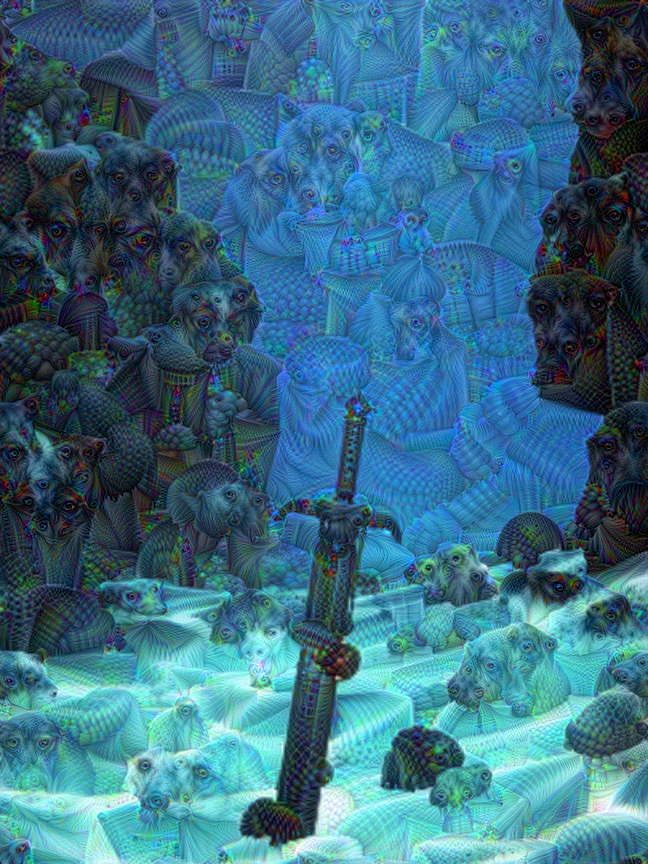

In [9]:
# 選ばれたレイヤーをoutputにしたモデルを作る
names = [layer_selector.value]
selected_layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=selected_layers)

base_shape = tf.shape(np_img)[:-1]
img = run_deep_dream_with_octaves(img=np_img,
                                    model=TiledGradients(dream_model),
                                    steps_per_octave=steps_per_octave_selector.value,
                                    step_size=step_size_selector.value,
                                    octaves=range(octaves_start_selector.value, octaves_start_selector.value + octaves_selector.value),
                                    octave_scale=octave_scale_selector.value)

# display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

# 下の出力画像は自作画像が加工元のため禁転載です